In [71]:
from helpers import *
import numpy as np
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D

inDir = '../'
varsName = 'jetVars'
#tracks = 'nom:RF75:RF75NB:loose:tight:A:B'.split(':')
tracks = 'nom:pseudo:ideal'.split(':')
tracks2 = 'nom:nom_RF75:nom_RF75_replaceFRAGWithTruth:nom_RF90'.split(':')
tracksAll = 'nom:nom_RF75:nom_RF75_replaceFRAGWithTruth:nom_RF90:pseudo:ideal'.split(':')
workDir = '/Users/avalee/TrackingAnalysis/'
outDir = workDir + 'plotDists'
if not (os.path.isdir(outDir)): os.makedirs(outDir)
styleDict = styleTracks()

ttbar = '410470_ttbar'
Zext = '427081_Zprime_extended'
Z = '427080'

jets = {"b": 5, "c": 4, "l": 0}

rateDict = {
    'jet_pt': [], #[(0, 2500), 25, 'Jet $p_T$ [GeV]']
    'llr_rate_pt': [(0, 2500), 25, 'Jet $p_T$ [GeV]']
}

distDict = {
    'jet_jf_llr': [(-1, 1), 100, 'Jet JF LLR']
}

In [23]:
def getallVars(inDir, version, tracks, dictName, varDict, splitJets=False):
    histoDict = collections.OrderedDict()
    for track in tracks:
        fileDict = getDict(inDir, version, track, dictName)
        df = pd.DataFrame.from_dict(fileDict)
        for var in varDict:
            if splitJets:
                for jet in jets.keys():
                    if 'rate' in var:
                        query = df.query('jet_LabDr_HadF ==' + str(jets[jet])+ ' & jet_jf_llr !=-99')['jet_pt']
                    else:
                        query = df.query('jet_LabDr_HadF ==' + str(jets[jet]))[var]
                    histoDict[track + '_' + var + '_' + jet] = query
            else:
                histoDict[track + '_' + var] = df[var]
    
    return histoDict          

In [10]:
def divideHisto(top, bottom, xBins, xRange):      
    hT, bin_edges = np.histogram(top, bins=xBins, range=xRange, density=True)
    hB, bin_edges = np.histogram(bottom, bins=xBins, range=xRange, density=True)
    ratio = getRatio(hT, hB)

    # Plot ratios
    left,right = bin_edges[:-1],bin_edges[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([ratio,ratio]).T.flatten()
        
    return ratio, left, right

In [85]:
def plotHisto(histoDict, tracks, var, xRange, xBins, varLabel, yLabel, splitJets=False, jet=''):
    figName = var
    
    #Plot histograms
    xMin, xMax = xRange
    ax1, ax2 = configureHistRatioPads(var, varLabel, yLabel, xMin, xMax)
    yMaxs = []
    for track in tracks:
        figName += '_' + track
        if 'rate' in var:
            if splitJets: pTHist = histoDict[track + '_jet_pt_' + jet]
            else: pTHist = histoDict[track + '_jet_pt']
            rateHisto, left, right = divideHisto(histoDict[track + '_' + var], pTHist, xBins, xRange)
            x = np.array([left,right]).T.flatten()
            y = np.array([rateHisto,rateHisto]).T.flatten()
            ax1.plot(x, y, color=styleDict[track][0], linewidth=1, label=styleDict[track][1])
            #ax1.plot([],[], color=styleDict[track][0], linewidth=1, label=styleDict[track][1]) #Add legend entries
            
        else:
            y, x, _ = ax1.hist(histoDict[track + '_' + var], bins=xBins, range=xRange, density=True,
                           color=styleDict[track][0], histtype='step')
            ax1.plot([],[], color=styleDict[track][0], linewidth=1, label=styleDict[track][1])
        yMaxs.append(y.max())    
        
        if 'rate' in var:
            if track == 'nom': # Save rate nom histo for dividing
                rateNom = rateHisto
            ratio = getRatio(rateHisto, rateNom)
        else:
            ratio, left, right = divideHisto(histoDict[track + '_' + var], histoDict['nom_' + var], xBins, xRange)

        X = np.array([left,right]).T.flatten()
        Y = np.array([ratio,ratio]).T.flatten()
        ax2.plot(X,Y, color=styleDict[track][0], linewidth=1)

        
    ax1.set_ylim([0, max(yMaxs)*1.35])
    if 'jet_trk' in var: ax1.set_ylim([0, max(yMaxs)*1.4])
    if splitJets:
        plt.text(0.93, 0.95, '%s-jet'%(jet), fontsize=9, transform=ax1.transAxes, style='italic') #weight='bold'

    #handles, labels = ax1.get_legend_handles_labels()
    #new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles] # Draw lines for legend
    if 'jet_trk' in var: loc="best"
    ax1.legend(loc="upper right", labelspacing=0.3, fontsize=7, facecolor='none', edgecolor='none')

    plt.savefig(outDir + "/" + figName +".pdf", bbox_inches='tight', pad_inches=0.04)
                

In [86]:
def plotAllHistos(inDir, version, tracks, dictName, varDict, splitJets=False):
    histoDict = getallVars(inDir, version, tracks, dictName, varDict, splitJets)
    yLabel = "Arbitrary units"
    for var, varValues in varDict.items():
        if var == 'jet_pt': continue
        xRange, xBins, varLabel = varValues
        if 'rate' in var:
            yLabel = "JF vertex reconstruction rate"
        if splitJets:
            for jet in jets.keys():
                plotHisto(histoDict, tracks, var + '_' + jet, xRange, xBins, varLabel, yLabel, splitJets, jet)
        else:
            plotHisto(histoDict, tracks, var, xRange, xBins, varLabel, yLabel, splitJets)

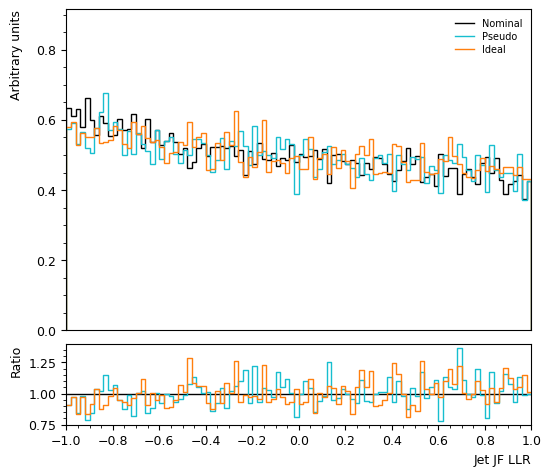

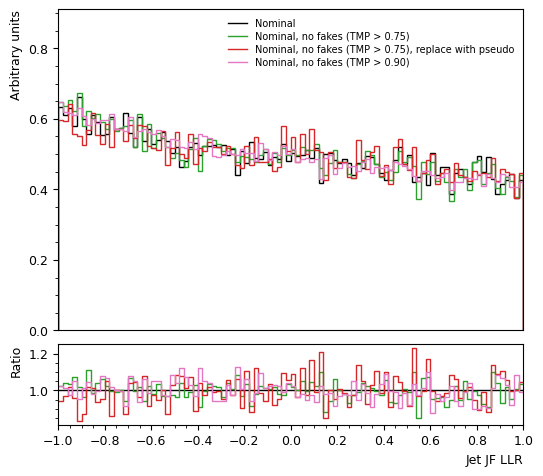

In [87]:
plotAllHistos(inDir, Z, tracks, "jetVars", distDict)
plotAllHistos(inDir, Z, tracks2, "jetVars", distDict)

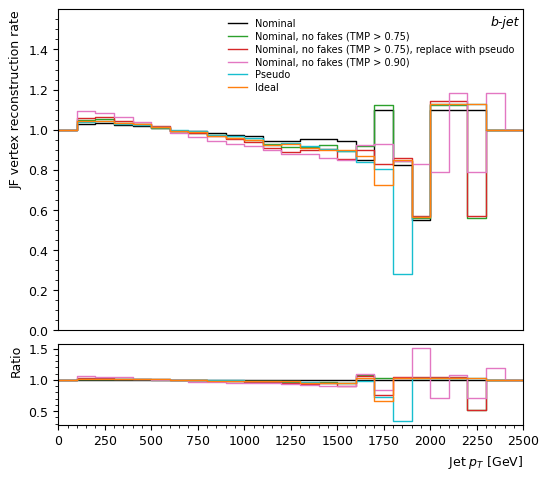

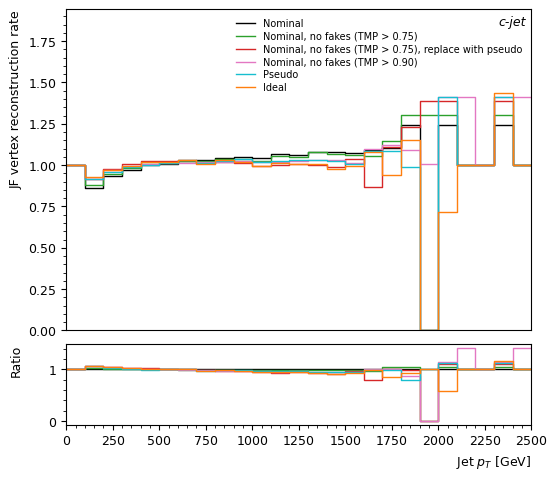

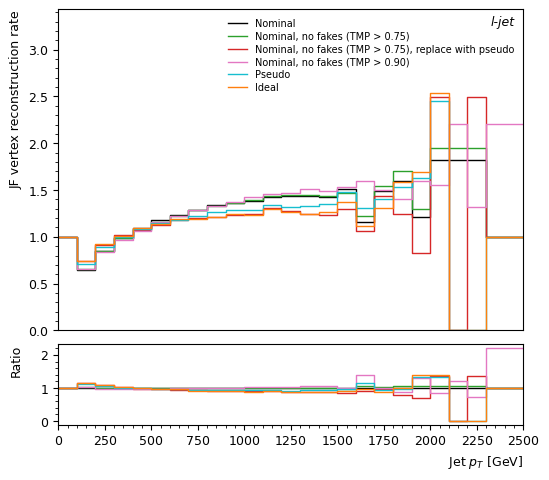

In [88]:
plotAllHistos(inDir, Z, tracksAll, "jetVars", rateDict, splitJets=True)